In [17]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import accuracy_score, matthews_corrcoef, f1_score, classification_report

In [2]:
# load merged dataset
df = pd.read_csv("Data/merged_dataset.csv", parse_dates=["Week"])

In [3]:
# Standardise column names (strip spaces, lower-case)
df.columns = [c.strip() for c in df.columns]

# Try to parse 'Week' as datetime if present
if 'Week' in df.columns:
    df['Week'] = pd.to_datetime(df['Week'], errors='coerce')
elif 'week' in df.columns:
    df['Week'] = pd.to_datetime(df['week'], errors='coerce')
else:
    # Fallback: try to infer from any date-like column
    possible_dates = [c for c in df.columns if 'date' in c.lower() or 'week' in c.lower()]
    if len(possible_dates) > 0:
        df['Week'] = pd.to_datetime(df[possible_dates[0]], errors='coerce')
    else:
        raise ValueError("No obvious weekly date column found. Expected a 'Week' column.")

In [5]:
# Sort chronologically and drop rows without Week
df = df.dropna(subset=['Week']).sort_values('Week').reset_index(drop=True)

In [6]:
# Step 2: Define protocol target from weekly Close and ±1% threshold

# Compute simple weekly return from Close
df = df.sort_values('Week').reset_index(drop=True)
df['Return_protocol'] = df['Close'].pct_change()

In [7]:
# Define 3-class target using ±1% threshold
delta = 0.01
def to_label(r):
    if pd.isna(r):
        return np.nan
    if r > delta:
        return 1
    if r < -delta:
        return -1
    return 0

df['Target_protocol'] = df['Return_protocol'].apply(to_label)

In [8]:
# Drop the first week (no target)
df_model = df.dropna(subset=['Target_protocol']).reset_index(drop=True)

In [9]:
# Quick check: class distribution
class_dist = df_model['Target_protocol'].value_counts().sort_index()
class_dist

Target_protocol
-1.0    70
 0.0    75
 1.0    94
Name: count, dtype: int64

In [10]:
# Step 3: Create rolling-origin expanding-window splits

N = len(df_model)
initial_train_weeks = max(52, int(0.5 * N))  # at least 1 year; roughly half the data
test_weeks = max(16, int(0.1 * N))          # at least ~quarter; roughly 10%
splits = []

train_end = initial_train_weeks - 1
split_id = 1
while True:
    test_start = train_end + 1
    test_end = test_start + test_weeks - 1
    if test_start >= N:
        break
    if test_end >= N:
        test_end = N - 1
    splits.append({
        "split_id": split_id,
        "train_start_idx": 0,
        "train_end_idx": int(train_end),
        "test_start_idx": int(test_start),
        "test_end_idx": int(test_end),
        "train_size": int(train_end - 0 + 1),
        "test_size": int(test_end - test_start + 1),
        "train_start_date": df_model.loc[0, 'Week'].date(),
        "train_end_date": df_model.loc[int(train_end), 'Week'].date(),
        "test_start_date": df_model.loc[int(test_start), 'Week'].date(),
        "test_end_date": df_model.loc[int(test_end), 'Week'].date(),
    })
    split_id += 1
    if test_end >= N - 1:
        break
    # expand training to include this test block for the next split
    train_end = test_end

splits_df = pd.DataFrame(splits)
splits_df

,split_id,train_start_idx,train_end_idx,test_start_idx,test_end_idx,train_size,test_size,train_start_date,train_end_date,test_start_date,test_end_date
0,1,0,118,119,141,119,23,2007-02-04,2010-07-18,2010-07-25,2011-02-20
1,2,0,141,142,164,142,23,2007-02-04,2011-02-20,2011-02-27,2011-10-16
2,3,0,164,165,187,165,23,2007-02-04,2011-10-16,2011-10-23,2012-07-08
3,4,0,187,188,210,188,23,2007-02-04,2012-07-08,2012-07-22,2013-02-17
4,5,0,210,211,233,211,23,2007-02-04,2013-02-17,2013-02-24,2013-09-29
5,6,0,233,234,238,234,5,2007-02-04,2013-09-29,2013-10-20,2013-12-01


In [12]:
# Step 4: Random Walk predictions per split and metrics
all_preds = []
metrics_rows = []

labels_order = [-1, 0, 1]

for _, row in splits_df.iterrows():
    sid = int(row['split_id'])
    tr_end = int(row['train_end_idx'])
    te_start = int(row['test_start_idx'])
    te_end = int(row['test_end_idx'])
    
    y_true = df_model.loc[te_start:te_end, 'Target_protocol'].astype(int).to_numpy()
    
    # Random-walk: predict this week as last week's actual
    # For the first test week, use the last training week's actual label
    prev_labels = df_model['Target_protocol'].astype(int).shift(1)
    # For the first test index, manually set to last train week's label
    prev_labels.iloc[te_start] = int(df_model.loc[tr_end, 'Target_protocol'])
    y_pred = prev_labels.loc[te_start:te_end].astype(int).to_numpy()
    
    # Metrics
    acc = accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    f1_w = f1_score(y_true, y_pred, average='weighted', labels=labels_order)
    f1_macro = f1_score(y_true, y_pred, average='macro', labels=labels_order)
    
    metrics_rows.append({
        "split_id": sid,
        "train_end": df_model.loc[tr_end, 'Week'].date(),
        "test_start": df_model.loc[te_start, 'Week'].date(),
        "test_end": df_model.loc[te_end, 'Week'].date(),
        "test_size": int(te_end - te_start + 1),
        "Accuracy": acc,
        "Weighted F1": f1_w,
        "Macro F1": f1_macro,
        "MCC": mcc,
    })
    
    # Store predictions
    split_pred_df = df_model.loc[te_start:te_end, ['Week']].copy()
    split_pred_df['split_id'] = sid
    split_pred_df['y_true'] = y_true
    split_pred_df['y_pred'] = y_pred
    all_preds.append(split_pred_df)

In [14]:
metrics_df = pd.DataFrame(metrics_rows)
rw_preds = pd.concat(all_preds, ignore_index=True)

In [15]:
metrics_df

,split_id,train_end,test_start,test_end,test_size,Accuracy,Weighted F1,Macro F1,MCC
0,1,2010-07-18,2010-07-25,2011-02-20,23,0.304348,0.313043,0.207407,-0.270092
1,2,2011-02-20,2011-02-27,2011-10-16,23,0.304348,0.304348,0.222222,-0.179487
2,3,2011-10-16,2011-10-23,2012-07-08,23,0.478261,0.480702,0.484795,0.205206
3,4,2012-07-08,2012-07-22,2013-02-17,23,0.347826,0.347826,0.235043,-0.120130
4,5,2013-02-17,2013-02-24,2013-09-29,23,0.478261,0.476700,0.479772,0.212035
5,6,2013-09-29,2013-10-20,2013-12-01,5,0.200000,0.240000,0.133333,-0.360844


In [28]:
# Compute pooled metrics across all OOS predictions

y_true_all = rw_preds['y_true'].astype(int).to_numpy()
y_pred_all = rw_preds['y_pred'].astype(int).to_numpy()

acc_all = accuracy_score(y_true_all, y_pred_all)
mcc_all = matthews_corrcoef(y_true_all, y_pred_all)
f1_w_all = f1_score(y_true_all, y_pred_all, average='weighted', labels=labels_order)
f1_macro_all = f1_score(y_true_all, y_pred_all, average='macro', labels=labels_order)

pooled_metrics = pd.DataFrame([{
    "Accuracy": acc_all,
    "Weighted F1": f1_w_all,
    "Macro F1": f1_macro_all,
    "MCC": mcc_all,
    "n_weeks": len(y_true_all)
}])

report_txt = classification_report(y_true_all, y_pred_all, labels=labels_order, digits=4, output_dict=True)

In [29]:
pooled_metrics

,Accuracy,Weighted F1,Macro F1,MCC,n_weeks
0,0.375,0.375262,0.37487,0.048128,120


In [30]:
print(pd.DataFrame(report_txt).transpose())

              precision    recall  f1-score  support
-1             0.354839  0.366667  0.360656   30.000
0              0.428571  0.418605  0.423529   43.000
1              0.340426  0.340426  0.340426   47.000
accuracy       0.375000  0.375000  0.375000    0.375
macro avg      0.374612  0.375232  0.374870  120.000
weighted avg   0.375614  0.375000  0.375262  120.000


In [31]:
# Step 5: Protocol figure — rolling-origin splits timeline (single-plot)

import matplotlib.pyplot as plt
import matplotlib.patches as patches

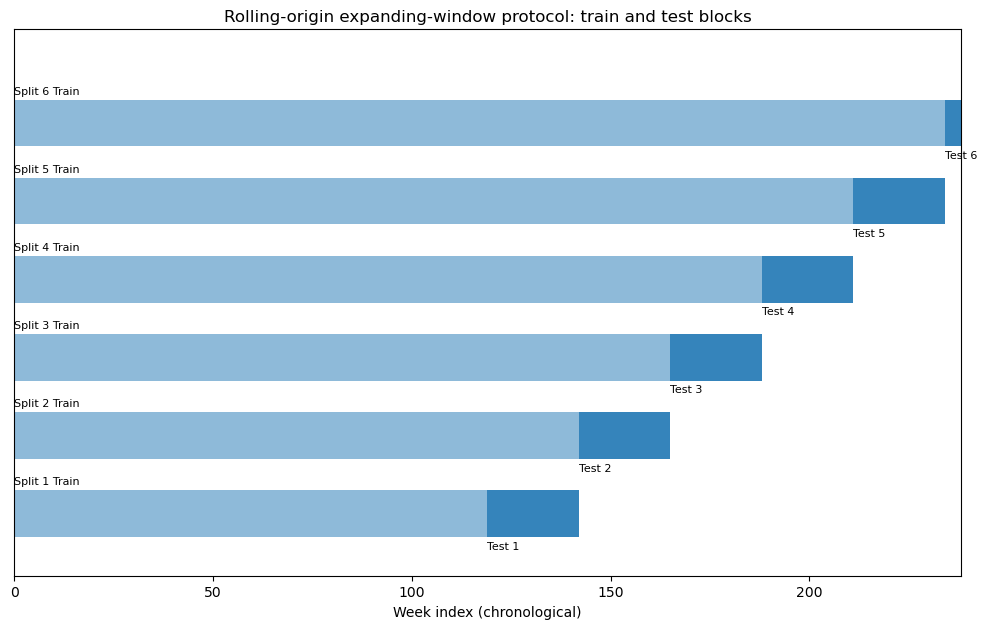

In [32]:
weeks = df_model['Week'].to_list()
fig, ax = plt.subplots(figsize=(10, 4 + 0.4*len(splits_df)))

y_offset = 0
height = 0.6

for _, r in splits_df.iterrows():
    sid = int(r['split_id'])
    # training block
    tr_start_i = int(r['train_start_idx'])
    tr_end_i = int(r['train_end_idx'])
    tr_rect = patches.Rectangle((tr_start_i, y_offset), tr_end_i - tr_start_i + 1, height, alpha=0.5)
    ax.add_patch(tr_rect)
    ax.text(tr_start_i, y_offset + height + 0.05, f"Split {sid} Train", fontsize=8, va='bottom')
    
    # test block
    te_start_i = int(r['test_start_idx'])
    te_end_i = int(r['test_end_idx'])
    te_rect = patches.Rectangle((te_start_i, y_offset), te_end_i - te_start_i + 1, height, alpha=0.9)
    ax.add_patch(te_rect)
    ax.text(te_start_i, y_offset - 0.05, f"Test {sid}", fontsize=8, va='top')
    
    y_offset += 1

ax.set_ylim(-0.5, y_offset + 0.5)
ax.set_xlim(0, len(df_model)-1)
ax.set_xlabel("Week index (chronological)")
ax.set_yticks([])
ax.set_title("Rolling-origin expanding-window protocol: train and test blocks")

plt.tight_layout()
plt.show()